# ***Autoencoder Based Approach for Image Similarity Search***

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from scipy.spatial.distance import cdist

In [2]:
# Defining Function for Loading and Preprocessing data.
def load_and_preprocess_data():
    """Load and preprocess the Fashion MNIST dataset."""
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.
    x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.
    return x_train, y_train, x_test, y_test

In [3]:
# Function for Building Autoencoder , training it and then generating embedding using it.
def build_autoencoder():
    """Build and compile the CNN-based autoencoder."""
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

def train_autoencoder(autoencoder, x_train, x_test):
    """Train the autoencoder."""
    autoencoder.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

def generate_embeddings(encoder, x_test):
    """Generate embeddings for the test set."""
    return encoder.predict(x_test)

In [4]:
# Functions for finding Similar images based on Embeddings , Evaluating the performance of the model.
def find_similar_images(embeddings, selected_indices, top_k):
    """Find and return indices of top-k similar images based on embeddings."""
    similar_images_indices = []
    for index in selected_indices:
        distances = cdist(embeddings[index:index+1], embeddings, 'euclidean')
        closest_indices = np.argsort(distances)[0][1:top_k+1]  # Exclude self
        similar_images_indices.append(closest_indices)
    return similar_images_indices

def evaluate_similarity_top_k(x_test, selected_indices, similar_images_indices, labels, top_k):
    """Evaluate similarity search using precision, recall, and retrieval accuracy for top-k images."""
    precision_list = []
    recall_list = []
    accuracy_count = 0

    for idx, sim_indices in zip(selected_indices, similar_images_indices):
        original_label = labels[idx]
        retrieved_labels = labels[sim_indices]

        # Calculate precision and recall
        true_positive = np.sum(retrieved_labels == original_label)
        precision = true_positive / top_k
        recall = true_positive / np.sum(labels == original_label)

        # Update metrics
        precision_list.append(precision)
        recall_list.append(recall)

        # Check if the most similar image is correctly identified
        if retrieved_labels[0] == original_label:
            accuracy_count += 1

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    retrieval_accuracy = accuracy_count / len(selected_indices)

    return avg_precision, avg_recall, retrieval_accuracy

def display_similar_images_top_k(x_test, selected_indices, similar_images_indices, top_k):
    """Visualize the original and top-k similar images."""
    plt.figure(figsize=(15, len(selected_indices) * 2))
    for i, (index, sim_indices) in enumerate(zip(selected_indices, similar_images_indices)):
        ax = plt.subplot(len(selected_indices), top_k + 1, i * (top_k + 1) + 1)
        plt.imshow(x_test[index].reshape(28, 28))
        plt.title("Original")
        plt.gray()
        ax.axis('off')

        for j, sim_index in enumerate(sim_indices):
            ax = plt.subplot(len(selected_indices), top_k + 1, i * (top_k + 1) + j + 2)
            plt.imshow(x_test[sim_index].reshape(28, 28))
            plt.title(f"Similar {j+1}")
            plt.gray()
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# Main workflow
x_train, y_train, x_test, y_test = load_and_preprocess_data()
autoencoder = build_autoencoder()
train_autoencoder(autoencoder, x_train, x_test)

# Extract encoder model
encoder = Model(autoencoder.input, autoencoder.layers[-7].output)
encoded_imgs = generate_embeddings(encoder, np.reshape(x_test, (len(x_test), 28, 28, 1)))
encoded_imgs_flatten = encoded_imgs.reshape((len(x_test), np.prod(encoded_imgs.shape[1:])))

# Select random test images for similarity search
np.random.seed(0)
selected_indices = np.random.choice(x_test.shape[0], 3, replace=False)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.4256 - val_loss: 0.3079
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3033 - val_loss: 0.2983
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2956 - val_loss: 0.2949
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2912 - val_loss: 0.2911
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2882 - val_loss: 0.2885
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2866 - val_loss: 0.2869
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2851 - val_loss: 0.2865
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2840 - val_loss: 0.2855
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2829 - val_loss: 0.2838
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2814 - val_loss: 0.2832
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2809 - val_loss: 0.2829
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/st

Top-3 Precision: 0.6667
Top-3 Recall: 0.0020
Top-3 Retrieval Accuracy: 0.6667


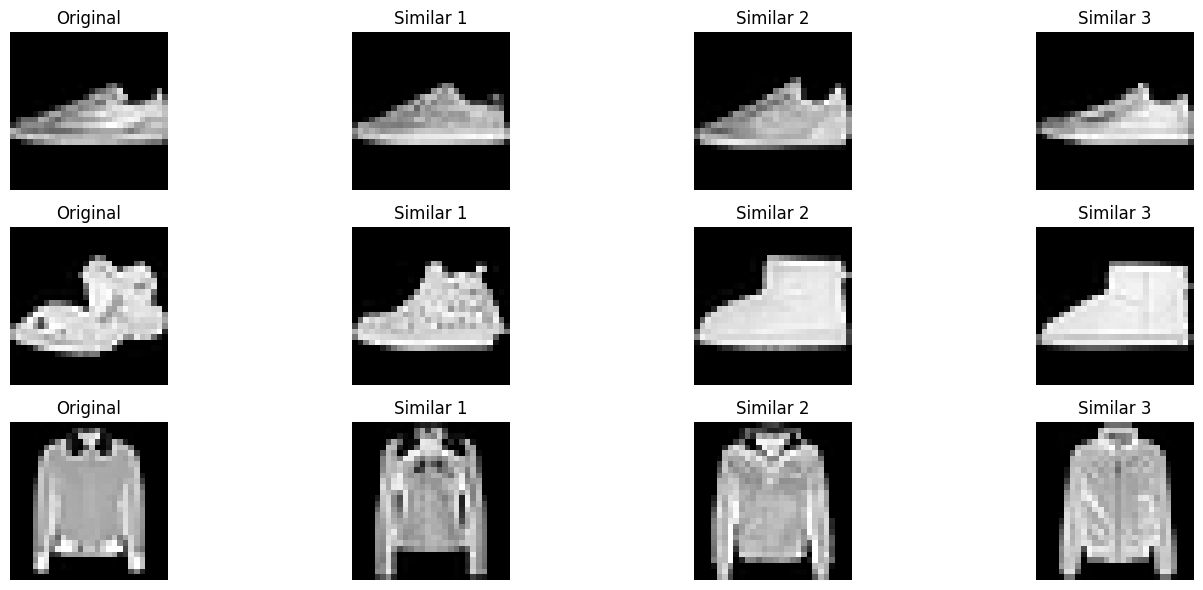

In [6]:
# Evaluate for top-3
top_k_3 = 3
similar_images_indices_3 = find_similar_images(encoded_imgs_flatten, selected_indices, top_k=top_k_3)
avg_precision_3, avg_recall_3, retrieval_accuracy_3 = evaluate_similarity_top_k(
    x_test, selected_indices, similar_images_indices_3, y_test, top_k=top_k_3
)
print(f"Top-{top_k_3} Precision: {avg_precision_3:.4f}")
print(f"Top-{top_k_3} Recall: {avg_recall_3:.4f}")
print(f"Top-{top_k_3} Retrieval Accuracy: {retrieval_accuracy_3:.4f}")
display_similar_images_top_k(x_test, selected_indices, similar_images_indices_3, top_k=top_k_3)

Top-5 Precision: 0.6667
Top-5 Recall: 0.0033
Top-5 Retrieval Accuracy: 0.6667


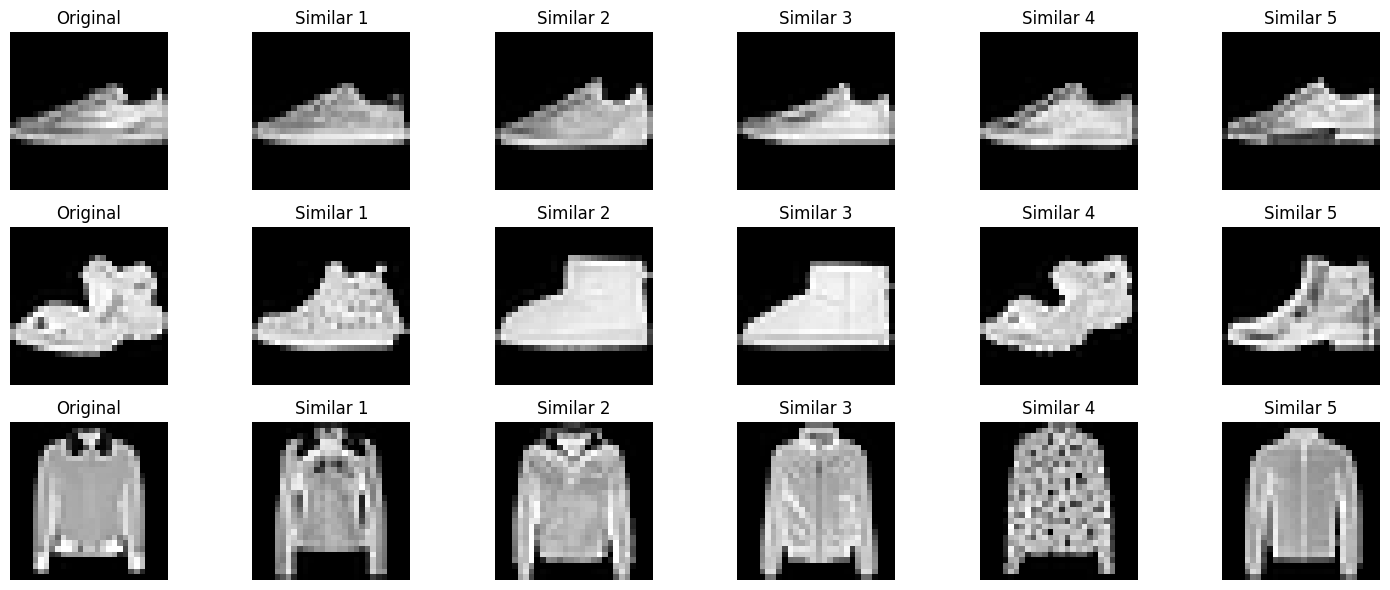

In [7]:
# Evaluate for top-5
top_k_5 = 5
similar_images_indices_5 = find_similar_images(encoded_imgs_flatten, selected_indices, top_k=top_k_5)
avg_precision_5, avg_recall_5, retrieval_accuracy_5 = evaluate_similarity_top_k(
    x_test, selected_indices, similar_images_indices_5, y_test, top_k=top_k_5
)
print(f"Top-{top_k_5} Precision: {avg_precision_5:.4f}")
print(f"Top-{top_k_5} Recall: {avg_recall_5:.4f}")
print(f"Top-{top_k_5} Retrieval Accuracy: {retrieval_accuracy_5:.4f}")
display_similar_images_top_k(x_test, selected_indices, similar_images_indices_5, top_k=top_k_5)